## Inception V1

## Here are the training results and process of Inception V1, detailed results and discussions will be presented with other Models in the final report.

## Library 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import glob
import time

#DATA
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

#CNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Convolution2D,MaxPooling2D,Flatten,Dense, AveragePooling2D,GlobalAveragePooling2D, Input
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten,Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.layers.merge import concatenate
from keras.models import Model
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix
from sklearn.metrics import accuracy_score
from keras.models import Model,load_model
#VIS
from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras.models import load_model #Tensorflow 2.0

## Data Preprocessing

In [ ]:
def Data_process(path): 
    '''
    parameters: path(STR) of the directory and flag(INT) to know if we prepare data of training or testing
    return: (LIST) of images of the dataset and the (LIST) of labels
    
    For training:
    -Read images of every directory and extract all images
    -Resize to (150,150,3)
    -Read the directory name and asign as a class
    '''
    X = []
    y = []
    for directory in sorted(glob.glob(os.path.join(path, '*')), key = lambda k: k.split("/")[-1]):
            for imgs in glob.glob(os.path.join(directory,'*.jpg')):
                img_cv = cv2.imread(imgs)
                img_cv = cv2.cvtColor(img_cv,cv2.COLOR_BGR2RGB)
                img_cv_r = cv2.resize(img_cv,(150,150))
                X.append(img_cv_r)
                y.append(int(directory.split("/")[-1].replace('c','')))    

    X_train, X_test, y_train, y_test =  train_test_split(X,y, test_size = 0.2)

    return np.array(X_train), np.array(X_test) ,np.array(y_train), np.array(y_test)

In [ ]:
#Paths
train_data_path = "/kaggle/input/state-farm-distracted-driver-detection/imgs/train/"
test_data_path =  "/kaggle/input/state-farm-distracted-driver-detection/imgs/test/"

#List of Images for Train and Test
X_train, X_test , y_train, y_test= Data_process(train_data_path)

print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)

X_train shape: (17939, 150, 150, 3)
y_train shape: (17939,)
X_test shape: (4485, 150, 150, 3)
y_test shape: (4485,)


In [ ]:
y_train_one = keras.utils.to_categorical(y_train,10)
y_test_one = keras.utils.to_categorical(y_test,10)

print('X_train shape:',X_train.shape)
print('y_train shape:',y_train_one.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test_one.shape)

X_train shape: (17939, 150, 150, 3)
y_train shape: (17939, 10)
X_test shape: (4485, 150, 150, 3)
y_test shape: (4485, 10)


## Data Observation

There are  [0 1 2 3 4 5 6 7 8 9] different labels in this dataset.
Labels count in y_train: [1979 1815 1860 1880 1853 1870 1858 1588 1539 1697]
Labels count in y_test: [510 452 457 466 473 442 467 414 372 432] 

Showing some examples of different labels



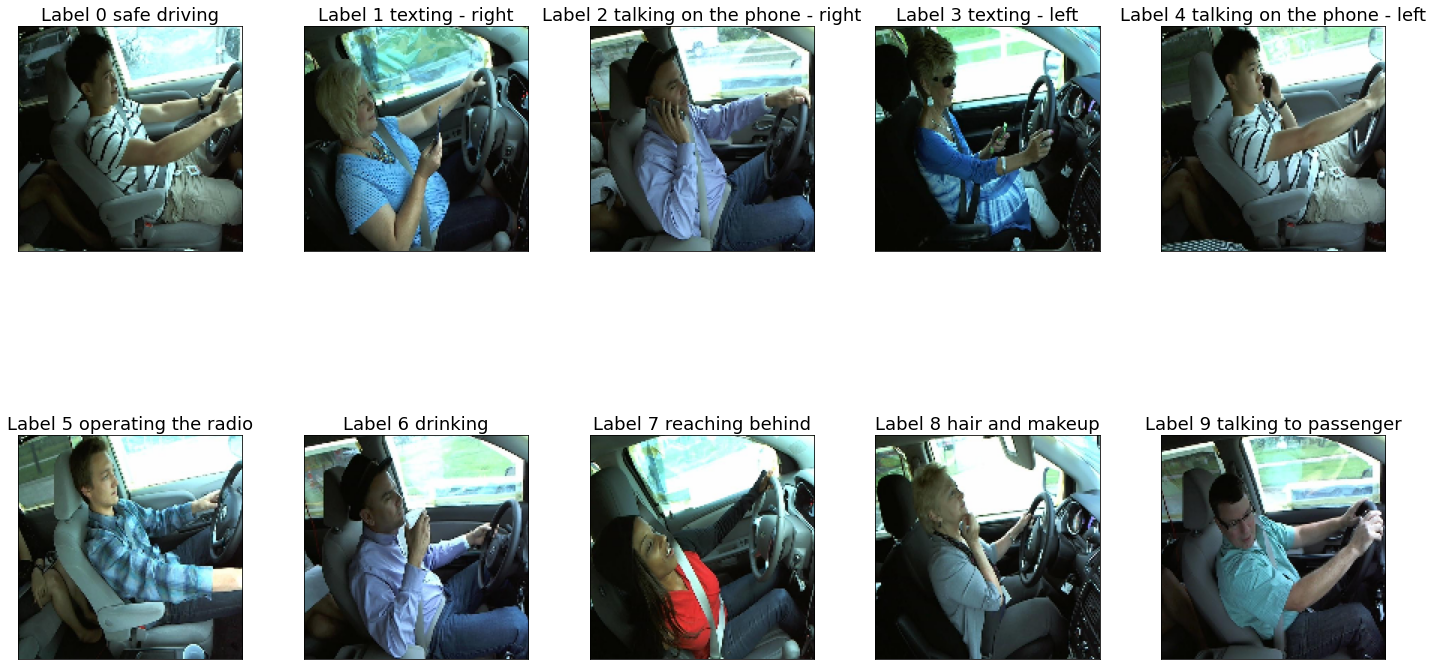

In [ ]:
print("There are ",np.unique(y_train),"different labels in this dataset.")
print('Labels count in y_train:', np.bincount(y_train))
print('Labels count in y_test:', np.bincount(y_test),'\n')

label = {"mask_name":[],"data":[]}
for i in np.unique(y_train):
    label["mask_name"].append("label " + str(i))
    label["data"].append(X_train[y_train==i,:])
    
labels=['safe driving','texting - right','talking on the phone - right'
        ,'texting - left','talking on the phone - left','operating the radio',
        'drinking','reaching behind','hair and makeup','talking to passenger']
print('Showing some examples of different labels\n')
#fig, axes = plt.subplots(2, 5, figsize = (5, 5))
fig = plt.figure(figsize = (20, 20))
for i in np.unique(y_train):
  ax = fig.add_subplot(2, 5, i+1)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(label["data"][i][1])
  ax.set_title('Label '+str(i)+' '+str(labels[i]), fontsize = 18)
  plt.tight_layout()

## Building Model

 ## InceptionV1

In [ ]:
from keras.models import Model,load_model
def Conv2d_BN(layer, nb_filter,kernel_size, padding='same',strides=(1,1)):

    layer = Conv2D(nb_filter,kernel_size,padding=padding,strides=strides,activation='relu')(layer)
    layer = BatchNormalization(axis=3)(layer)

    return layer
  
def Inception(layer,conv1x1_branch_1,conv1x1_branch_2,conv3x3_branch_2,conv1x1_branch_3,conv5x5_branch_3,conv1x1_branch_4):
    branch1 = Conv2D(conv1x1_branch_1,(1,1), padding='same',strides=(1,1))(layer)

    branch2 = Conv2D(conv1x1_branch_2,(1,1), padding='same',strides=(1,1),)(layer)
    branch2 = Conv2D(conv3x3_branch_2,(3,3), padding='same',strides=(1,1),)(branch2)

    branch3 = Conv2D(conv1x1_branch_3,(1,1), padding='same',strides=(1,1))(layer)
    branch3 = Conv2D(conv5x5_branch_3,(1,1), padding='same',strides=(1,1))(branch3)

    branch4 = MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same')(layer)
    branch4 = Conv2D(conv1x1_branch_4,(1,1),padding='same',strides=(1,1))(branch4)

    layer = concatenate([branch1,branch2,branch3,branch4],axis=3)

    return layer
  
def InceptionV1(width, height, depth, classes):
    
    inpt = Input(shape=(width,height,depth))

    layer = Conv2d_BN(inpt,64,(7,7),strides=(2,2),padding='same')
    layer = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(layer)
    layer = Conv2d_BN(layer,192,(3,3),strides=(1,1),padding='same')
    layer = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(layer)

    layer = Inception(layer,64,96,128,16,32,32) #3a
    layer = Inception(layer,128,128,192,32,96,64) #3b
    layer = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(layer) 

    layer = Inception(layer,192,96,208,16,48,64) #4a 
    layer = Inception(layer,160,112,224,24,64,64) #4a
    layer = Inception(layer,128,128,256,24,64,64) #4a
    layer = Inception(layer,112,144,288,32,64,64) #4a 
    layer = Inception(layer,256,160,320,32,128,128) #4a
    layer = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(layer) 

    layer = Inception(layer,256,160,320,32,128,128) #5a
    layer = Inception(layer,384,192,384,48,128,128) #5b

    layer = AveragePooling2D(pool_size=(7,7),strides=(7,7),padding='same')(layer)
    layer =Flatten()(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(1000,activation='relu')(layer)
    layer = Dense(classes,activation='softmax')(layer)
    
    model=Model(inputs=inpt,outputs=layer)
    
    return model



Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_360 (Conv2D)             (None, 75, 75, 64)   9472        input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_360 (BatchN (None, 75, 75, 64)   256         conv2d_360[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 38, 38, 64)   0           batch_normalization_360[0][0]    
______________________________________________________________________________________

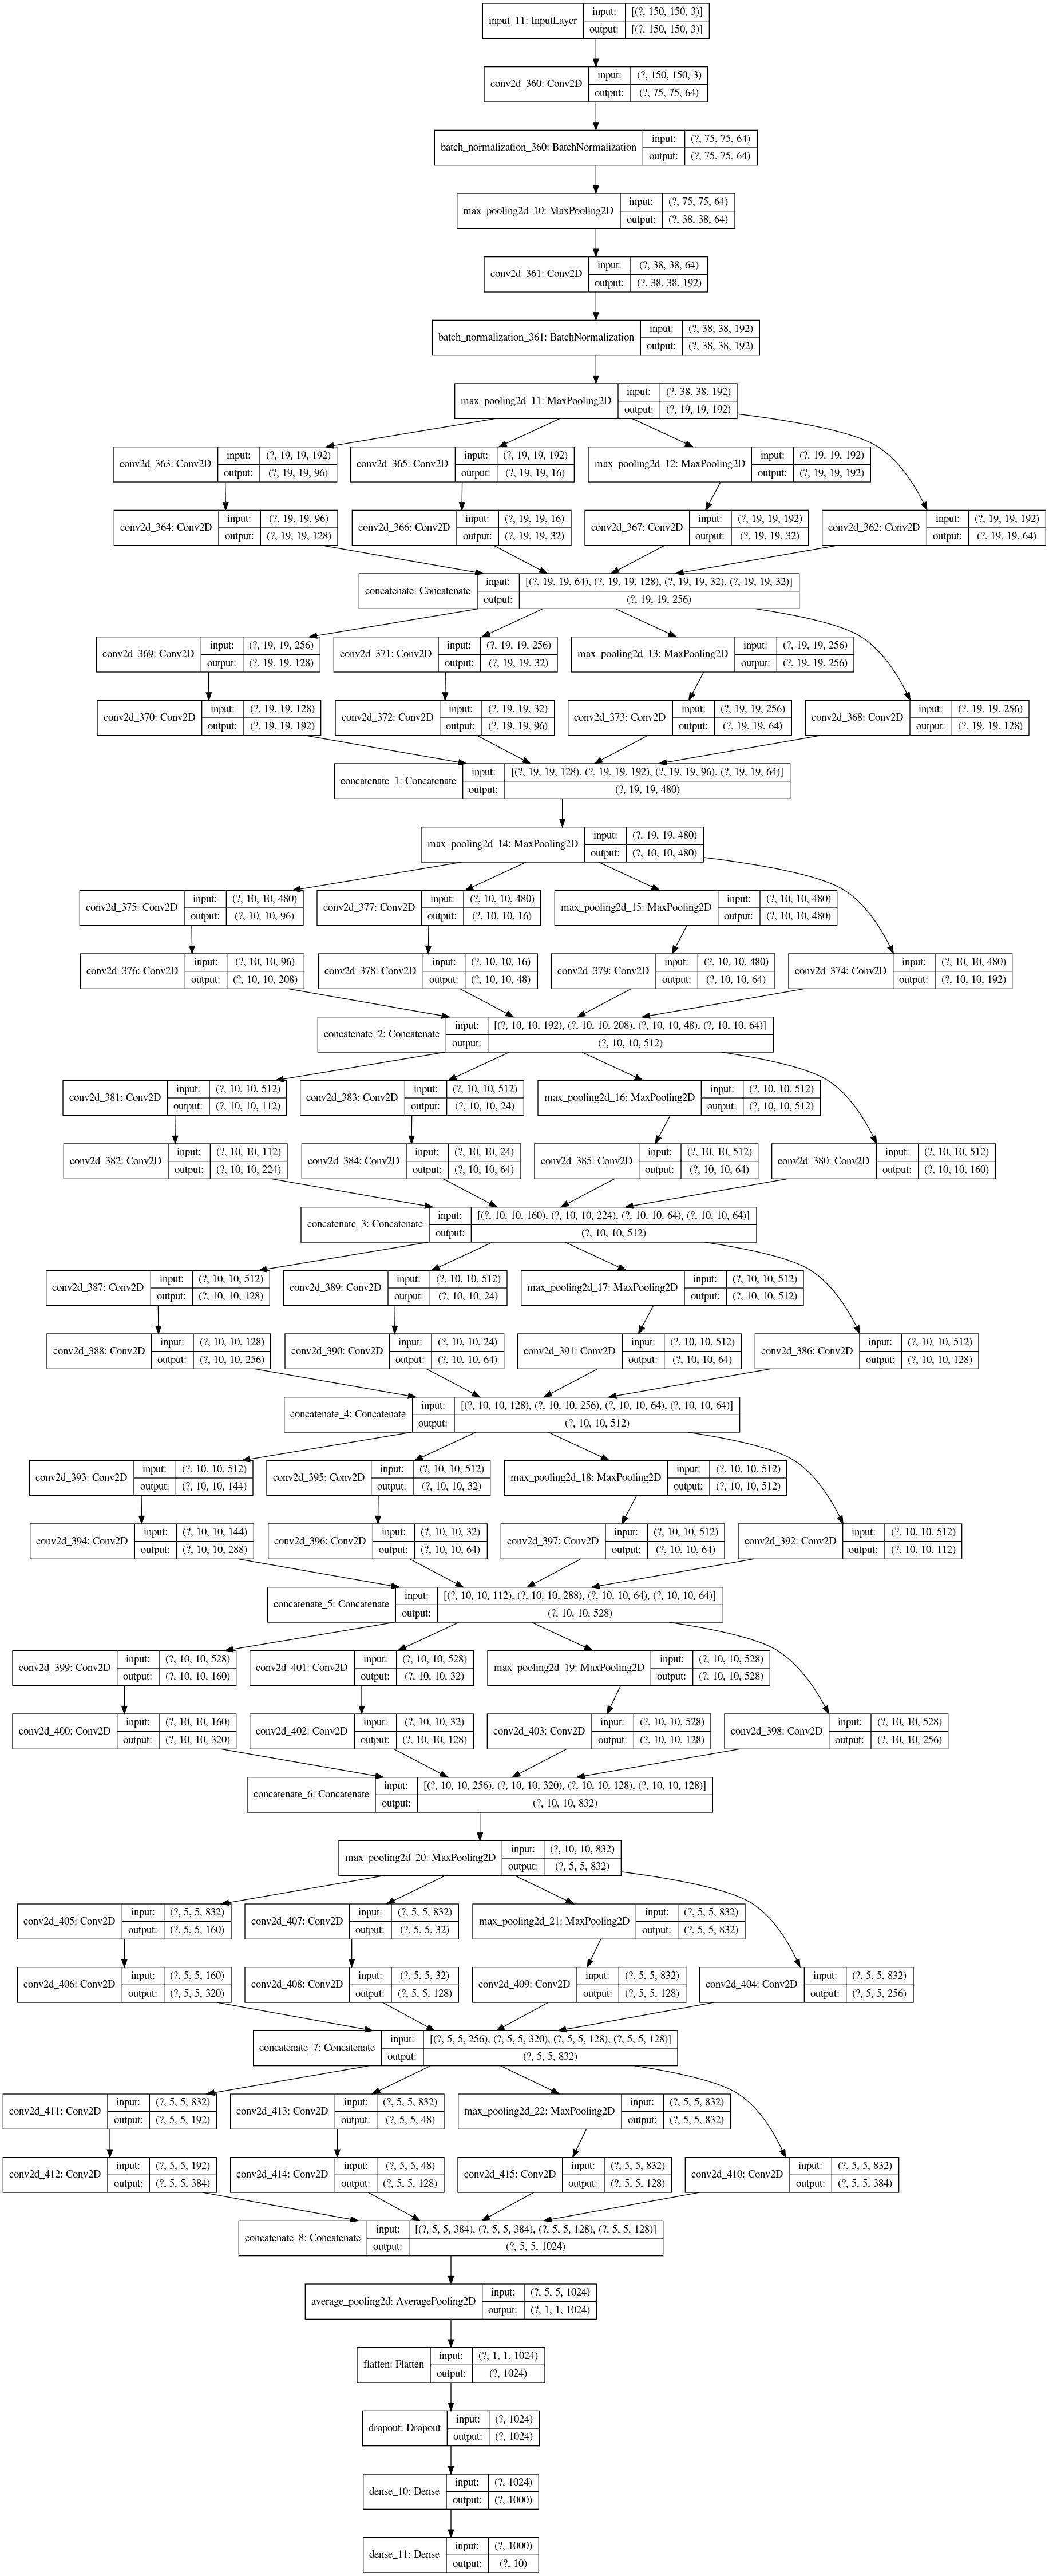

In [ ]:
InceptionV1_model = InceptionV1(150,150,3,10)
InceptionV1_model.summary()
plot_model(InceptionV1_model, show_shapes=True)

## Training InceptionV1

Learning rate： 0.0001 & Batch size： 16
Epoch 1/10
897/897 [==============================] - ETA: 0s - loss: 1.7260 - accuracy: 0.5051
Epoch 00001: val_loss improved from inf to 0.38990, saving model to InceptionV1_best_weight1.hdf5
897/897 [==============================] - 29s 32ms/step - loss: 1.7260 - accuracy: 0.5051 - val_loss: 0.3899 - val_accuracy: 0.8643
Epoch 2/10
897/897 [==============================] - ETA: 0s - loss: 0.3132 - accuracy: 0.9002
Epoch 00002: val_loss improved from 0.38990 to 0.21614, saving model to InceptionV1_best_weight1.hdf5
897/897 [==============================] - 28s 32ms/step - loss: 0.3132 - accuracy: 0.9002 - val_loss: 0.2161 - val_accuracy: 0.9348
Epoch 3/10
897/897 [==============================] - ETA: 0s - loss: 0.1886 - accuracy: 0.9437
Epoch 00003: val_loss did not improve from 0.21614
897/897 [==============================] - 27s 31ms/step - loss: 0.1886 - accuracy: 0.9437 - val_loss: 0.2993 - val_accuracy: 0.9164
Epoch 4/10
896/897 [===

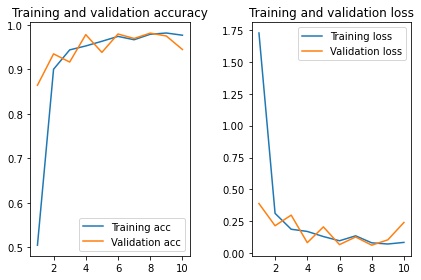

Learning rate： 0.0001 & Batch size： 32
Epoch 1/10
449/449 [==============================] - ETA: 0s - loss: 1.9893 - accuracy: 0.4435
Epoch 00001: val_loss improved from inf to 0.49391, saving model to InceptionV1_best_weight2.hdf5
449/449 [==============================] - 21s 46ms/step - loss: 1.9893 - accuracy: 0.4435 - val_loss: 0.4939 - val_accuracy: 0.8526
Epoch 2/10
448/449 [============================>.] - ETA: 0s - loss: 0.3396 - accuracy: 0.8888
Epoch 00002: val_loss improved from 0.49391 to 0.39571, saving model to InceptionV1_best_weight2.hdf5
449/449 [==============================] - 20s 45ms/step - loss: 0.3402 - accuracy: 0.8886 - val_loss: 0.3957 - val_accuracy: 0.8852
Epoch 3/10
448/449 [============================>.] - ETA: 0s - loss: 0.1655 - accuracy: 0.9502
Epoch 00003: val_loss improved from 0.39571 to 0.14916, saving model to InceptionV1_best_weight2.hdf5
449/449 [==============================] - 21s 46ms/step - loss: 0.1654 - accuracy: 0.9502 - val_loss: 0.

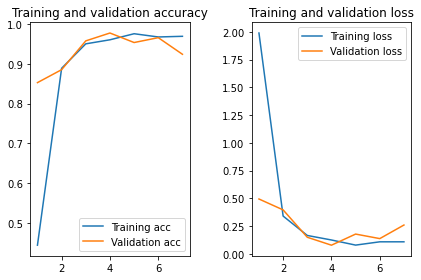

Learning rate： 0.0001 & Batch size： 48
Epoch 1/10
299/299 [==============================] - ETA: 0s - loss: 1.8960 - accuracy: 0.4552
Epoch 00001: val_loss improved from inf to 0.44298, saving model to InceptionV1_best_weight3.hdf5
299/299 [==============================] - 21s 69ms/step - loss: 1.8960 - accuracy: 0.4552 - val_loss: 0.4430 - val_accuracy: 0.8704
Epoch 2/10
299/299 [==============================] - ETA: 0s - loss: 0.3683 - accuracy: 0.8830
Epoch 00002: val_loss improved from 0.44298 to 0.10786, saving model to InceptionV1_best_weight3.hdf5
299/299 [==============================] - 19s 62ms/step - loss: 0.3683 - accuracy: 0.8830 - val_loss: 0.1079 - val_accuracy: 0.9688
Epoch 3/10
299/299 [==============================] - ETA: 0s - loss: 0.1531 - accuracy: 0.9514
Epoch 00003: val_loss did not improve from 0.10786
299/299 [==============================] - 18s 61ms/step - loss: 0.1531 - accuracy: 0.9514 - val_loss: 0.1413 - val_accuracy: 0.9554
Epoch 4/10
299/299 [===

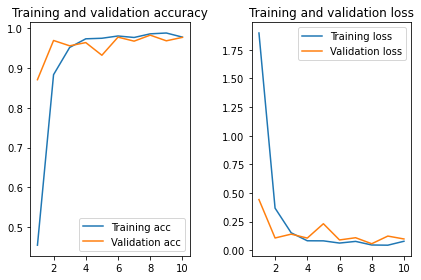

Learning rate： 0.0005 & Batch size： 16
Epoch 1/10
896/897 [============================>.] - ETA: 0s - loss: 2.1157 - accuracy: 0.4730
Epoch 00001: val_loss improved from inf to 1.45785, saving model to InceptionV1_best_weight4.hdf5
897/897 [==============================] - 29s 32ms/step - loss: 2.1143 - accuracy: 0.4733 - val_loss: 1.4579 - val_accuracy: 0.6037
Epoch 2/10
897/897 [==============================] - ETA: 0s - loss: 0.5133 - accuracy: 0.8346
Epoch 00002: val_loss improved from 1.45785 to 0.36766, saving model to InceptionV1_best_weight4.hdf5
897/897 [==============================] - 28s 31ms/step - loss: 0.5133 - accuracy: 0.8346 - val_loss: 0.3677 - val_accuracy: 0.8746
Epoch 3/10
896/897 [============================>.] - ETA: 0s - loss: 0.3484 - accuracy: 0.8945
Epoch 00003: val_loss did not improve from 0.36766
897/897 [==============================] - 28s 31ms/step - loss: 0.3481 - accuracy: 0.8946 - val_loss: 0.3778 - val_accuracy: 0.8673
Epoch 4/10
897/897 [===

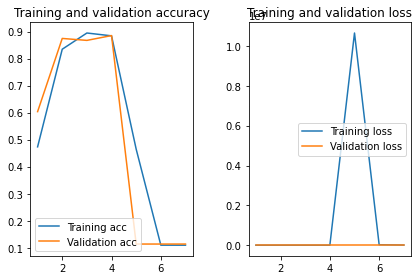

Learning rate： 0.0005 & Batch size： 32
Epoch 1/10
449/449 [==============================] - ETA: 0s - loss: 2.4166 - accuracy: 0.4864
Epoch 00001: val_loss improved from inf to 0.51296, saving model to InceptionV1_best_weight5.hdf5
449/449 [==============================] - 21s 46ms/step - loss: 2.4166 - accuracy: 0.4864 - val_loss: 0.5130 - val_accuracy: 0.8283
Epoch 2/10
449/449 [==============================] - ETA: 0s - loss: 0.4157 - accuracy: 0.8624
Epoch 00002: val_loss improved from 0.51296 to 0.20487, saving model to InceptionV1_best_weight5.hdf5
449/449 [==============================] - 20s 45ms/step - loss: 0.4157 - accuracy: 0.8624 - val_loss: 0.2049 - val_accuracy: 0.9415
Epoch 3/10
449/449 [==============================] - ETA: 0s - loss: 0.2086 - accuracy: 0.9360
Epoch 00003: val_loss did not improve from 0.20487
449/449 [==============================] - 20s 45ms/step - loss: 0.2086 - accuracy: 0.9360 - val_loss: 0.2304 - val_accuracy: 0.9312
Epoch 4/10
448/449 [===

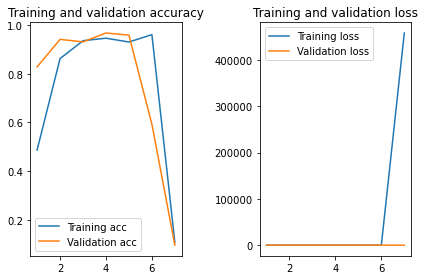

Learning rate： 0.0005 & Batch size： 48
Epoch 1/10
299/299 [==============================] - ETA: 0s - loss: 2.7958 - accuracy: 0.4082
Epoch 00001: val_loss improved from inf to 0.72647, saving model to InceptionV1_best_weight6.hdf5
299/299 [==============================] - 19s 65ms/step - loss: 2.7958 - accuracy: 0.4082 - val_loss: 0.7265 - val_accuracy: 0.7517
Epoch 2/10
299/299 [==============================] - ETA: 0s - loss: 0.4455 - accuracy: 0.8526
Epoch 00002: val_loss improved from 0.72647 to 0.31310, saving model to InceptionV1_best_weight6.hdf5
299/299 [==============================] - 19s 65ms/step - loss: 0.4455 - accuracy: 0.8526 - val_loss: 0.3131 - val_accuracy: 0.9005
Epoch 3/10
299/299 [==============================] - ETA: 0s - loss: 0.1755 - accuracy: 0.9467
Epoch 00003: val_loss improved from 0.31310 to 0.20038, saving model to InceptionV1_best_weight6.hdf5
299/299 [==============================] - 18s 62ms/step - loss: 0.1755 - accuracy: 0.9467 - val_loss: 0.

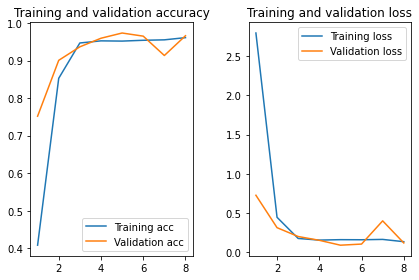

Learning rate： 0.001 & Batch size： 16
Epoch 1/10
897/897 [==============================] - ETA: 0s - loss: 6.9685 - accuracy: 0.3162
Epoch 00001: val_loss improved from inf to 1.39320, saving model to InceptionV1_best_weight7.hdf5
897/897 [==============================] - 28s 32ms/step - loss: 6.9685 - accuracy: 0.3162 - val_loss: 1.3932 - val_accuracy: 0.4632
Epoch 2/10
896/897 [============================>.] - ETA: 0s - loss: 0.7909 - accuracy: 0.7215
Epoch 00002: val_loss improved from 1.39320 to 0.57487, saving model to InceptionV1_best_weight7.hdf5
897/897 [==============================] - 28s 31ms/step - loss: 0.7907 - accuracy: 0.7215 - val_loss: 0.5749 - val_accuracy: 0.7963
Epoch 3/10
897/897 [==============================] - ETA: 0s - loss: 0.4058 - accuracy: 0.8683
Epoch 00003: val_loss did not improve from 0.57487
897/897 [==============================] - 27s 31ms/step - loss: 0.4058 - accuracy: 0.8683 - val_loss: 0.6357 - val_accuracy: 0.7999
Epoch 4/10
897/897 [====

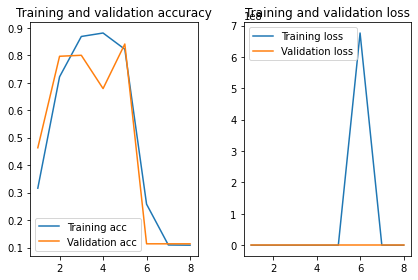

Learning rate： 0.001 & Batch size： 32
Epoch 1/10
449/449 [==============================] - ETA: 0s - loss: 10.3976 - accuracy: 0.2372
Epoch 00001: val_loss improved from inf to 2.37397, saving model to InceptionV1_best_weight8.hdf5
449/449 [==============================] - 21s 46ms/step - loss: 10.3976 - accuracy: 0.2372 - val_loss: 2.3740 - val_accuracy: 0.2071
Epoch 2/10
448/449 [============================>.] - ETA: 0s - loss: 1.1442 - accuracy: 0.5749
Epoch 00002: val_loss improved from 2.37397 to 0.58404, saving model to InceptionV1_best_weight8.hdf5
449/449 [==============================] - 20s 45ms/step - loss: 1.1434 - accuracy: 0.5754 - val_loss: 0.5840 - val_accuracy: 0.8085
Epoch 3/10
449/449 [==============================] - ETA: 0s - loss: 0.5843 - accuracy: 0.7990
Epoch 00003: val_loss improved from 0.58404 to 0.43280, saving model to InceptionV1_best_weight8.hdf5
449/449 [==============================] - 20s 45ms/step - loss: 0.5843 - accuracy: 0.7990 - val_loss: 0

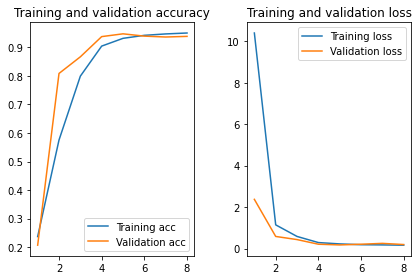

Learning rate： 0.001 & Batch size： 48
Epoch 1/10
299/299 [==============================] - ETA: 0s - loss: 8.2579 - accuracy: 0.2587
Epoch 00001: val_loss improved from inf to 1.32412, saving model to InceptionV1_best_weight9.hdf5
299/299 [==============================] - 19s 64ms/step - loss: 8.2579 - accuracy: 0.2587 - val_loss: 1.3241 - val_accuracy: 0.5365
Epoch 2/10
299/299 [==============================] - ETA: 0s - loss: 0.9078 - accuracy: 0.6701
Epoch 00002: val_loss improved from 1.32412 to 0.60043, saving model to InceptionV1_best_weight9.hdf5
299/299 [==============================] - 19s 62ms/step - loss: 0.9078 - accuracy: 0.6701 - val_loss: 0.6004 - val_accuracy: 0.8096
Epoch 3/10
299/299 [==============================] - ETA: 0s - loss: 0.3870 - accuracy: 0.8708
Epoch 00003: val_loss improved from 0.60043 to 0.40881, saving model to InceptionV1_best_weight9.hdf5
299/299 [==============================] - 18s 62ms/step - loss: 0.3870 - accuracy: 0.8708 - val_loss: 0.4

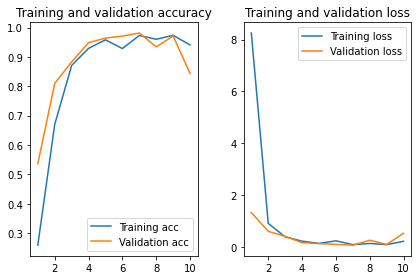

In [ ]:
from keras.callbacks import ModelCheckpoint

#path creation
base_filename='InceptionV1_best_weight'
filename_suffix = 'hdf5'
k=1
learning_rate=[0.0001, 0.0005, 0.001]
batch_size=[16, 32, 48]
for i in (learning_rate):
    for j in (batch_size):
        print("Learning rate：", i ,"& Batch size：", j)
        InceptionV1_model = InceptionV1(150,150,3,10)
        InceptionV1_model.compile(optimizer=Adam(lr=i, beta_1=0.9, beta_2=0.999, epsilon=1e-08),loss = 'categorical_crossentropy',metrics=['accuracy'])
        tStart = time.time()#計時開始
## save best model

        number = str(k)
        filepath=os.path.join(base_filename + number + "." + filename_suffix)
        early_stop  = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        callbacks_list = [checkpoint]
        hist_InceptionV1 = InceptionV1_model.fit(X_train,y_train_one,batch_size=j,epochs=10,validation_split=0.2, callbacks=[early_stop, checkpoint], verbose=1)
        tEnd = time.time()#計時結束
        k+=1
        print("Training Time :",tEnd-tStart,"\n")
        
        scores = InceptionV1_model.evaluate(X_test,y_test_one,verbose=1)
        acc = hist_InceptionV1.history['accuracy']
        val_acc = hist_InceptionV1.history['val_accuracy']
        loss = hist_InceptionV1.history['loss']
        val_loss = hist_InceptionV1.history['val_loss']
        epochs = range(1, len(acc) + 1)
        plt.subplot(1, 2, 1)
        plt.plot(epochs, acc, label='Training acc')
        plt.plot(epochs, val_acc, label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(epochs, loss, label='Training loss')
        plt.plot(epochs, val_loss, label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
       
        

# Confusion Matrix

Accuracy 0.9821627647714605
Confusion matrix


(<Figure size 648x648 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f359c7de810>)

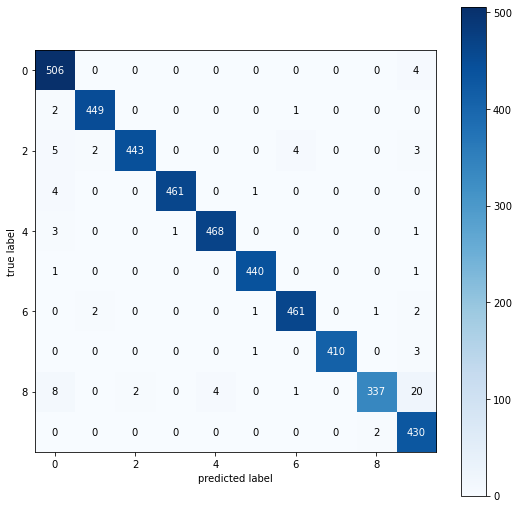

In [ ]:
best_model = tf.keras.models.load_model('InceptionV1_best_weight3.hdf5')
y_pr=best_model.predict(X_test)
y_pred=[]
for i in range(len(y_pr)):
    y_pred.append(np.argmax(y_pr[i]))

cm=confusion_matrix(y_test,y_pred)
ac=accuracy_score(y_test,y_pred)
print("Accuracy", ac)
print("Confusion matrix")
plot_confusion_matrix(cm,figsize=(9,9),colorbar=True)

## Filter and Feature Observation

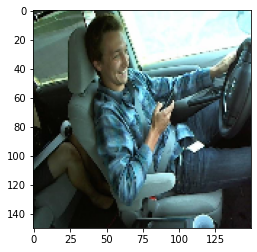

In [ ]:
img_arr = image.img_to_array(X_test[0])
img_arr = np.expand_dims(img_arr, axis=0)
img_arr /= 255.
plt.imshow(X_test[0])

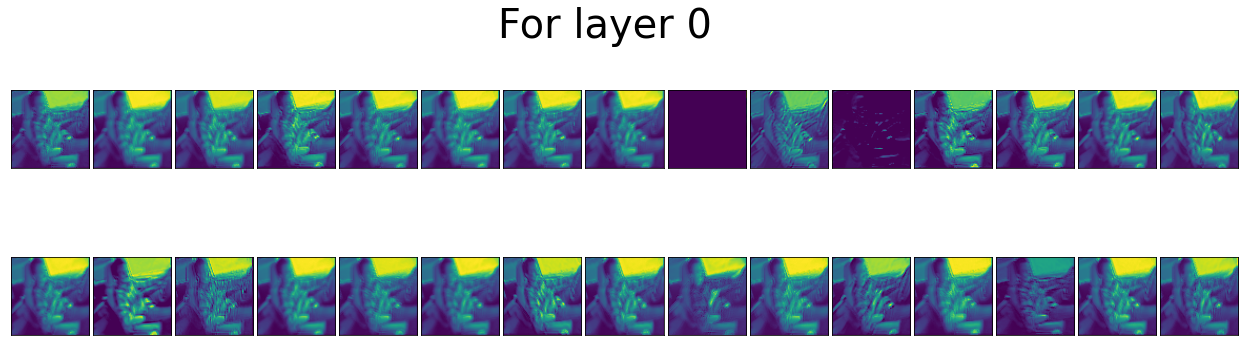

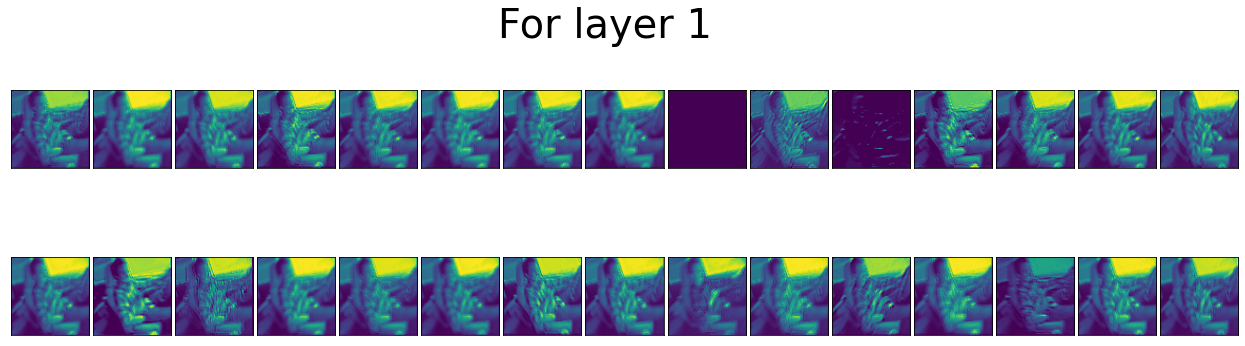

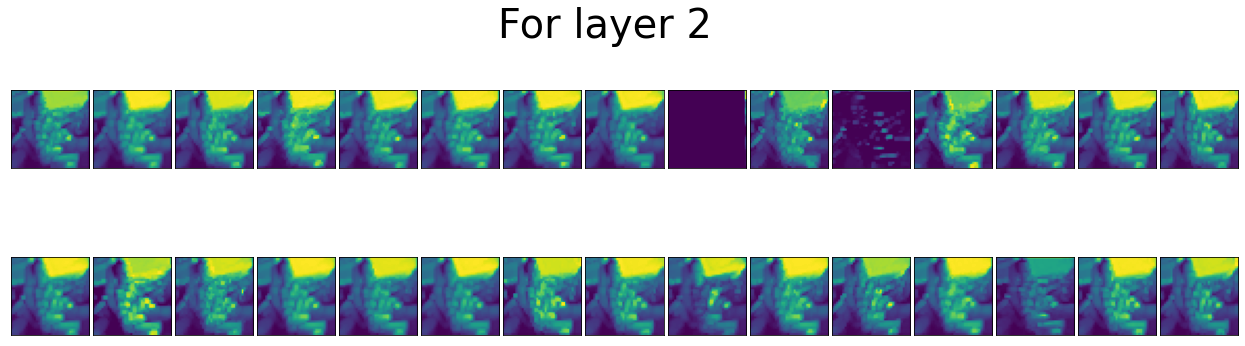

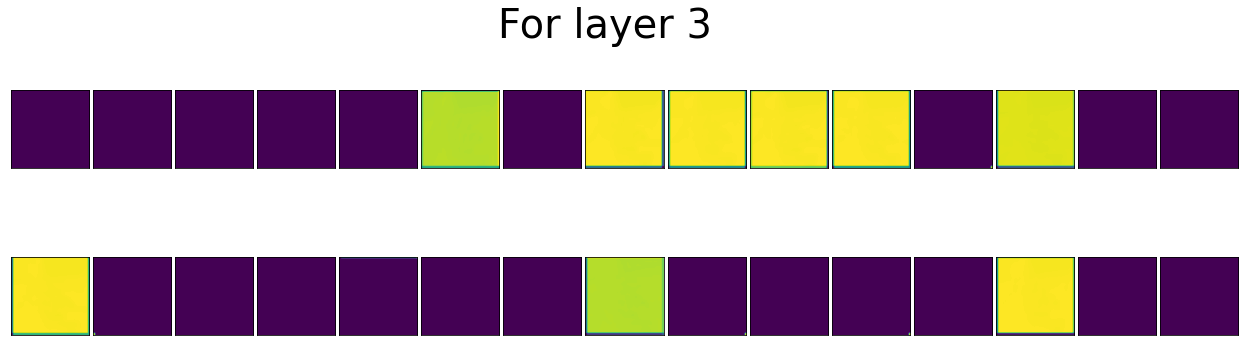

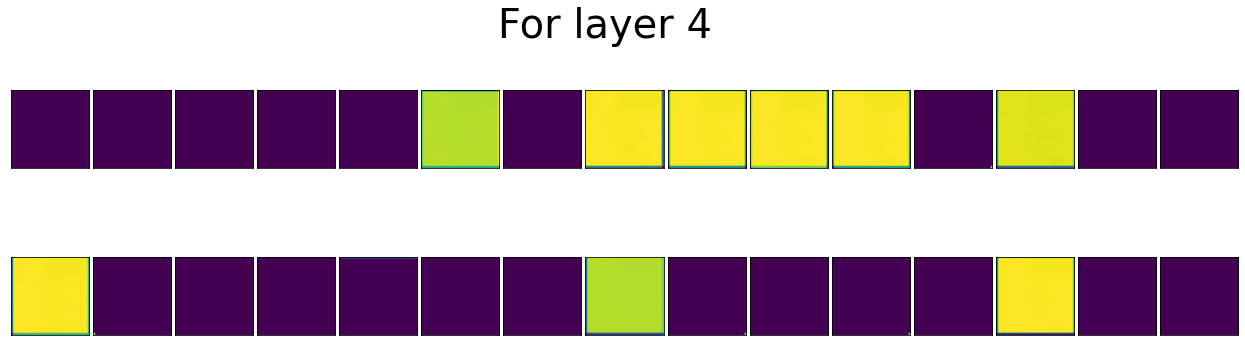

In [ ]:
layer_outputs = [layer.output for layer in InceptionV1_model.layers[1:100]]
activation_model = Model(inputs=InceptionV1_model.input, outputs=layer_outputs)
activations = activation_model.predict(img_arr)

# These are names of layers, the outputs of which we are going to visualize.
layer_names = ['conv2d_1', 'activation_1', 'conv2d_4', 'activation_4', 'conv2d_9', 'activation_9']
activ_list = [activations[0], activations[2], activations[10], activations[12], activations[17], activations[19]]


convolution_layer = ['First convolution', 'Third convolution', 'Fourth convolution', 'Next convolution afterward', 'ReLU activated output afterward'  ]
for i in range(5):
    fig = plt.figure(figsize=(22, 6))
    message = f"For layer {i}"
    for img in range(30):
    
        plt.suptitle(message, fontsize=40)
        ax = fig.add_subplot(2, 15, img+1)
        ax = plt.imshow(activations[i][0, :, :, img])
        plt.xticks([])
        plt.yticks([])
        fig.subplots_adjust(wspace=0.05, hspace=0.05)